## TRAINING RETE NEURALE - classificazione captcha

In [3]:
# Import
import torch

In [4]:
# Setup device
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

cuda


In [5]:
# Define transform
import torchvision.transforms as T
# Define single transforms

# Note: transforms can also be regular functions
def normalize_(x):
    # Set values
    x[x > 0.5] = 1
    x[x <= 0.5] = -1
    # Return
    return x


normalize = normalize_


In [6]:
#resize 48x48
def resize_(img):   
    size = 48,48
    img = img.resize(size)
    return img

resize = resize_

In [7]:
transform = T.Compose([T.Grayscale(num_output_channels=1),
                       resize,
                       T.ToTensor(),
                       normalize])

In [8]:
# Class map
class_names = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I',9:"J",10:"K",11:"L",12:"M",13:"N",14:"O",15:"P",16:"Q",17:"R",18:"S",19:"T",20:"U",21:"V",22:"W",23:"X",24:"Y",25:"Z"};

In [9]:
import string
#string.ascii_uppercase

In [10]:
# Imports
from PIL import Image, ImageChops
from random import shuffle
from glob import glob
import os
from matplotlib import pyplot as plt
%matplotlib inline

### Model definition

In [1]:
# Imports
import torch.nn as nn
import torch.nn.functional as F

# Convolutional layer
class ConvLayer(nn.Sequential):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.add_module('conv', nn.Conv2d(in_features, out_features, kernel_size=3))
        self.add_module('relu', nn.ReLU())
        self.add_module('pool', nn.MaxPool2d(kernel_size=2, stride=2))
        
# Convolutional layer
class ConvLayerBN(nn.Sequential):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.add_module('conv', nn.Conv2d(in_features, out_features, kernel_size=3))
        self.add_module('relu', nn.ReLU())
        self.add_module('bn', nn.BatchNorm2d(out_features))
        self.add_module('pool', nn.MaxPool2d(kernel_size=2, stride=2))

# Define model
class Model(nn.Module):
    def __init__(self):
        # Call parent
        super().__init__()
        # Convolutional layers
        self.convs = nn.Sequential(
            ConvLayerBN(1, 32),
            ConvLayerBN(32, 128)
        )
        # Computing encoding size
        self.convs.eval()
        test_x = torch.zeros(1, 1, 48,48) #DIMENSIONE IN PIXEL
        test_x = self.convs(test_x)
        encoding_size = test_x.numel()
        print(f"Encoding size: {encoding_size}")
        # FC layers
        self.fcs = nn.Sequential(
            nn.Linear(encoding_size, 2048),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(2048, len(class_names))
        )
        
    def forward(self, x):
        # Compute output
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        x = self.fcs(x)
        return x

### Datatets

In [10]:
# Define root directory
root_dir = "./output/"

In [11]:
# Imports
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torch.utils.data import DataLoader
import PIL

batch_size=32

# Instantiate datasets
letter_train_dataset = ImageFolder(os.path.join(root_dir,  "train"), transform) #, loader=loader)
letter_val_dataset = ImageFolder(os.path.join(root_dir,  "val"), transform) #, loader=loader)
letter_test_dataset = ImageFolder(os.path.join(root_dir,  "test"), transform) #, loader=loader)

# Get number of classes (we'll need it in the model)
num_classes = len(letter_train_dataset.classes)

# Print dataset statistics
print(f"Num. classes: {num_classes}")
print(f"Num. train samples: {len(letter_train_dataset)}")
print(f"Num. valid. samples: {len(letter_val_dataset)}")
print(f"Num. test samples: {len(letter_test_dataset)}")


# Instantiate data loaders
loaders = {"train": DataLoader(dataset=letter_train_dataset, batch_size=batch_size, shuffle=True,  num_workers=0, pin_memory=True),
           "val":   DataLoader(dataset=letter_val_dataset,   batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True),
           "test":  DataLoader(dataset=letter_test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
          }

Num. classes: 26
Num. train samples: 42588
Num. valid. samples: 14196
Num. test samples: 14222


In [12]:
letter_train_dataset[0][0].size()

torch.Size([1, 48, 48])

In [13]:
letter_train_dataset[40][0]

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

### Train the Model

In [14]:
# Load checkpoint
start_epoch = 0
checkpoint = f"checkpoint-{start_epoch}.pth"
use_checkpoint = False

In [15]:
# Check checkpoint
if use_checkpoint:
    state_dict = torch.load(checkpoint)
else:
    start_epoch = 0

# Create model for training
model = Model()
if use_checkpoint:
    model.load_state_dict(state_dict)
model.to(dev)

Encoding size: 12800


Model(
  (convs): Sequential(
    (0): ConvLayerBN(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (relu): ReLU()
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvLayerBN(
      (conv): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1))
      (relu): ReLU()
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fcs): Sequential(
    (0): Linear(in_features=12800, out_features=2048, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_features=2048, out_features=2048, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5)
    (6): Linear(in_features=2048, out_features=26, bias=True)
  )
)

In [16]:
# Imports
import torch.optim

# Create optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=5e-4)

In [17]:
# Test model output
model.eval()
test_input = letter_train_dataset[0][0].unsqueeze(0).to(dev)
print("Model output size:", model(test_input).size())

Model output size: torch.Size([1, 26])


In [23]:
# options
num_epochs = 36
save_every = 6

# Initialize training history

loss_history = {'train': [], 'val': [], 'test': []}
accuracy_history = {'train': [], 'val': [], 'test': []}
# Keep track of best validation accuracy
best_val_accuracy = 0
test_accuracy_at_best_val = 0
# Start training
print("Start training")
for epoch in range(num_epochs):
    # Initialize accumulators for computing average loss/accuracy
    epoch_loss_sum = {'train': 0, 'val': 0, 'test': 0}
    epoch_loss_cnt = {'train': 0, 'val': 0, 'test': 0}
    epoch_accuracy_sum = {'train': 0, 'val': 0, 'test': 0}
    epoch_accuracy_cnt = {'train': 0, 'val': 0, 'test': 0}
    # Process each split
    for split in ["train", "val", "test"]:
        # Set network mode
        if split == "train":
            model.train()
            torch.set_grad_enabled(True)
        else:
            model.eval()
            torch.set_grad_enabled(False)
        # Process all data in split
        for (input,target) in loaders[split]:
            # Move to device
            input = input.to(dev)
            target = target.to(dev)
            # Forward
            output = model(input)
            loss = F.cross_entropy(output, target)
            # Update loss sum
            epoch_loss_sum[split] += loss.item()
            epoch_loss_cnt[split] += 1
            # Compute accuracy
            _,pred = output.max(1)
            correct = pred.eq(target).sum().item()
            accuracy = correct/input.size(0)
            # Update accuracy sum
            epoch_accuracy_sum[split] += accuracy
            epoch_accuracy_cnt[split] += 1
            # Backward and optimize
            if split == "train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    # Compute average epoch loss/accuracy
    avg_train_loss = epoch_loss_sum["train"]/epoch_loss_cnt["train"]
    avg_train_accuracy = epoch_accuracy_sum["train"]/epoch_accuracy_cnt["train"]
    avg_val_loss = epoch_loss_sum["val"]/epoch_loss_cnt["val"]
    avg_val_accuracy = epoch_accuracy_sum["val"]/epoch_accuracy_cnt["val"]
    avg_test_loss = epoch_loss_sum["test"]/epoch_loss_cnt["test"]
    avg_test_accuracy = epoch_accuracy_sum["test"]/epoch_accuracy_cnt["test"]
    print(f"Epoch: {epoch+1}, TL={avg_train_loss:.4f}, TA={avg_train_accuracy:.4f}, VL={avg_val_loss:.4f}, VA={avg_val_accuracy:.4f}, ŦL={avg_test_loss:.4f}, ŦA={avg_test_accuracy:.4f}")
    # Add to histories
    loss_history["train"].append(avg_train_loss)
    loss_history["val"].append(avg_val_loss)
    loss_history["test"].append(avg_test_loss)
    accuracy_history["train"].append(avg_train_accuracy)
    accuracy_history["val"].append(avg_val_accuracy)
    accuracy_history["test"].append(avg_test_accuracy)
    # Check best validation
    if avg_val_accuracy > best_val_accuracy:
        # Update best validation
        best_val_accuracy = avg_val_accuracy
        test_accuracy_at_best_val = avg_test_accuracy
   
    # Save checkpoint
    if epoch > 0 and epoch % save_every == 0:
        state_dict = model.state_dict()
        #for k,v in state_dict.items():
           # state_dict[k] = v.cpu() #conversione CUDA - CPU
        torch.save(state_dict, f"checkpoint-{epoch}.pth")

Start training
Epoch: 1, TL=0.4761, TA=0.8573, VL=0.3313, VA=0.9096, ŦL=0.3311, ŦA=0.9088
Epoch: 2, TL=0.4072, TA=0.8791, VL=0.2857, VA=0.9199, ŦL=0.2849, ŦA=0.9234
Epoch: 3, TL=0.3505, TA=0.8948, VL=0.2554, VA=0.9278, ŦL=0.2550, ŦA=0.9294
Epoch: 4, TL=0.3105, TA=0.9087, VL=0.2198, VA=0.9377, ŦL=0.2230, ŦA=0.9384
Epoch: 5, TL=0.2728, TA=0.9211, VL=0.2002, VA=0.9423, ŦL=0.2034, ŦA=0.9428
Epoch: 6, TL=0.2421, TA=0.9303, VL=0.1805, VA=0.9484, ŦL=0.1833, ŦA=0.9480
Epoch: 7, TL=0.2173, TA=0.9375, VL=0.1656, VA=0.9525, ŦL=0.1686, ŦA=0.9513
Epoch: 8, TL=0.1980, TA=0.9439, VL=0.1537, VA=0.9543, ŦL=0.1575, ŦA=0.9537
Epoch: 9, TL=0.1789, TA=0.9495, VL=0.1405, VA=0.9594, ŦL=0.1457, ŦA=0.9577
Epoch: 10, TL=0.1634, TA=0.9546, VL=0.1322, VA=0.9619, ŦL=0.1361, ŦA=0.9609
Epoch: 11, TL=0.1509, TA=0.9585, VL=0.1250, VA=0.9647, ŦL=0.1292, ŦA=0.9629
Epoch: 12, TL=0.1364, TA=0.9629, VL=0.1189, VA=0.9657, ŦL=0.1232, ŦA=0.9633
Epoch: 13, TL=0.1263, TA=0.9667, VL=0.1129, VA=0.9661, ŦL=0.1182, ŦA=0.9647
Epoch:

In [24]:
# Print test accuracy at best validation accuracy
print(f"Final test accuracy {test_accuracy_at_best_val:.4f}")

Final test accuracy 0.9796


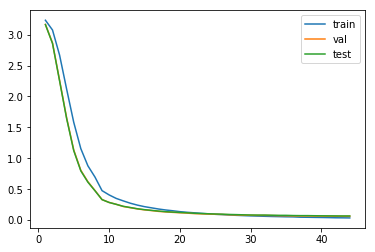

In [25]:
# Plot loss
x = torch.arange(1, len(loss_history["train"])+1).numpy()
plt.plot(x, loss_history["train"], label="train")
plt.plot(x, loss_history["val"], label="val")
plt.plot(x, loss_history["test"], label="test")
plt.legend()
plt.show()

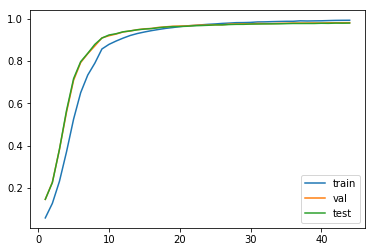

In [26]:
# Plot accuracy
x = torch.arange(1, len(loss_history["train"])+1).numpy()
plt.plot(x, accuracy_history["train"], label="train")
plt.plot(x, accuracy_history["val"], label="val")
plt.plot(x, accuracy_history["test"], label="test")
plt.legend()
plt.show()

In [27]:
#Save the model
model_name="captcha72k"
# Define root directory
save_path = f"./{model_name}{num_epochs}.pt"
modello_salvato = model.state_dict()
torch.save(modello_salvato, save_path)

### Test the Model
Testing del modello trainato.

In [15]:
model = Model()
#model.load_state_dict(torch.load("./modello30.pt",map_location=dev))
model.load_state_dict(torch.load("./captcha72k36.pt",map_location=dev)) 
model.eval()

model.cuda()

Encoding size: 12800


Model(
  (convs): Sequential(
    (0): ConvLayerBN(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (relu): ReLU()
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvLayerBN(
      (conv): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1))
      (relu): ReLU()
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fcs): Sequential(
    (0): Linear(in_features=12800, out_features=2048, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_features=2048, out_features=2048, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5)
    (6): Linear(in_features=2048, out_features=26, bias=True)
  )
)

Test del modello su un captcha indicato

Predicted: U  with accuracy of: 99.99
Predicted: N  with accuracy of: 99.99
Predicted: I  with accuracy of: 99.80
Predicted: C  with accuracy of: 99.98
Predicted: T  with accuracy of: 99.97


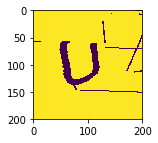

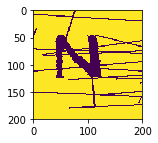

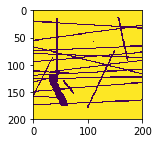

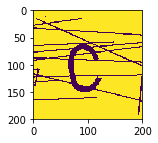

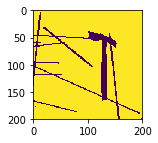

In [16]:
# Define root directory
prova_dir = "./CaptchaTest/"

nome_file = "UNICT25.png"

img = Image.open(os.path.join(prova_dir,nome_file))

width, _ = img.size

label = ""

num_lett = int(width/200)
for i in range(0,num_lett):
    plt.figure(figsize=(2, 2)) #deve stare dentro per plottare le immmagini
    img = Image.open(os.path.join(prova_dir, nome_file))
    #img = img.convert('1')
    #crop ogni 200px 5 volte
    #0,0 200,200 - 200,0 400,200 - 400,0 600, 200
    current_box = img.crop((200*i,0,200*(i+1),200))

    input = transform(current_box)
    plt.imshow(current_box)
    # Predict class
    model.eval()
    with torch.no_grad():
        output = model(input.unsqueeze(0).to(dev))
    accuracy = output.softmax(1).max(1)
    accuracy = accuracy[0].item()*100
    _,pred = output.max(1)
    pred = pred.item()
    print(f"Predicted: {class_names[pred]}  with accuracy of: {'%.2f'%(accuracy)}")
    #print("secondo", f"{'%.2f'%(secondo)}")
    #plt.show(input)



